# Get PCA components for the 830 subjects in the ImageNomer test cohort

In [5]:
import pickle

metadictname = '../PNC_agesexwrat.pkl'
alltsname = '../PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [77]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return sorted(list(allsubs))

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [78]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.16], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
print(p[0].shape)

(830, 34716)


In [79]:
# Decompose resting state fMRI

from sklearn.decomposition import PCA

pca = PCA().fit(p[0])
rest_comp = pca.transform(p[0])

print(rest_comp.shape)

(830, 830)


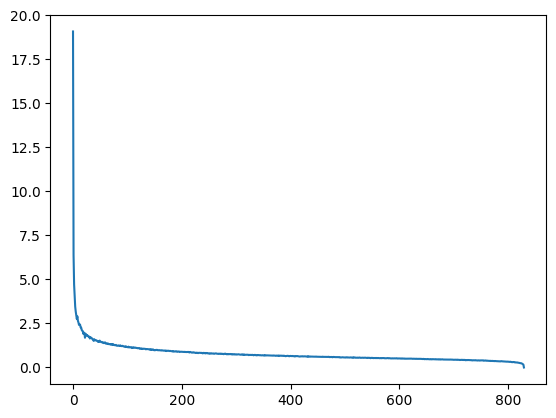

In [80]:
# Visualize distribution of rest components

import matplotlib.pyplot as plt

rest_dist = np.mean(np.abs(rest_comp), axis=0)
plt.plot(rest_dist)
plt.show()

In [81]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8, 
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print(len(ours2orig))

264


(830, 34716)


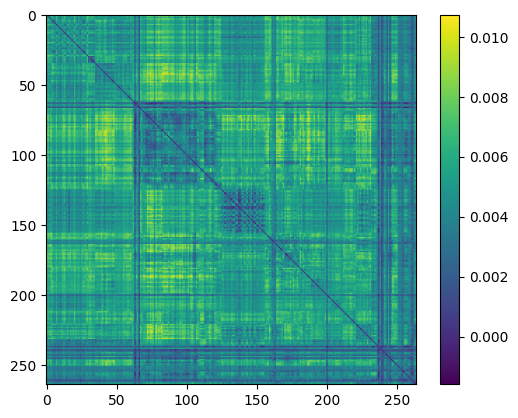

In [82]:
# Visualize top components

print(pca.components_.shape)
top = pca.components_[0]

a,b = np.triu_indices(264,1)
top_img = np.zeros((264,264))
top_img[a,b] = top
top_img = top_img + top_img.T
top_img = remap(top_img)

plt.imshow(top_img)
plt.colorbar()
plt.show()

# PCA works perfectly when transforming both train and test set
Estimating components on just the train set is what causes the U-shaped curve

In [92]:
# Regress age using top 100 PCA components

from sklearn.linear_model import LinearRegression

ntrain = 700
idcs = np.random.permutation(rest_comp.shape[0])

x = rest_comp
xtr = x[idcs[:ntrain]]
xt = x[idcs[ntrain:]]

y = get_y(metadict, ['age'], subs)[0]
ytr = y[idcs[:ntrain]]
yt = y[idcs[ntrain:]]

mu = np.mean(y)
ytr = ytr - mu
yt = yt - mu

clf = LinearRegression().fit(xtr, ytr)
yhat = clf.predict(xt)
rmse = np.mean((yhat-yt)**2)**0.5

print(rmse)

29.8297958072027


In [93]:
# Dump components into directory
# Filename is dictionaryName_comp-compIdx.npy

dict_name = 'restpca'
basedir = f'../components/{dict_name}-components'

for i in range(pca.components_.shape[0]):
    fname = f'{basedir}/{dict_name}_comp-{i}.npy'
    np.save(fname, pca.components_[i])
    
print('Complete')

Complete


In [97]:
# Dump weights into directory
# Filename is subId_components-dictionaryName_weights.npy

dict_name = 'restpca'
basedir = f'../components/{dict_name}-weights'

for i,sub in enumerate(subs):
    fname = f'{basedir}/{sub}_comp-{dict_name}_weights.npy'
    np.save(fname, rest_comp[i])
    
print('Complete')

Complete
